# Chapter 20: Network-Driven Supervised Machine Learning

## 20.1 The Basics of Supervised Machine Learning

* **Feature**: Inputs designed to make *classes*
* **Classes**: Classifications of things based on input *features*
* **Classifier**: A model that can identify classes based on features
* **Regressor**: A model that predicts numeric values; e.g. the price of a car or house

In [22]:
# Loading iris features and class labels
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
num_classes = len(set(y))
print(f"We have {y.size} labeled examples across the following {num_classes} classes:\n{set(y)}\n")
print(f"First four feature rows:\n{X[:4]}")
print(f"\nFirst four labels:\n{y[:4]}")

We have 150 labeled examples across the following 3 classes:
{0, 1, 2}

First four feature rows:
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]]

First four labels:
[0 0 0 0]


In [23]:
# Creating a training set
sampling_size = int(y.size / 4)
X_train, y_train = X[:sampling_size], y[:sampling_size]
print(f"Training set labels:\n{y_train}")

Training set labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


**Test Set**: Features and classes outside of our training set; these outputs can be utilized to test the classifier after training

In [24]:
# Creating a training set through random sampling
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(0)

# train_size=0.25 ensures 25% of our total data winds up in the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.25) 
print(f"Training set labels:\n{y_train}")

Training set labels:
[0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 1 1 0 1 2 2 0 1 1 1 1 0 0 0 2 1 2 0]


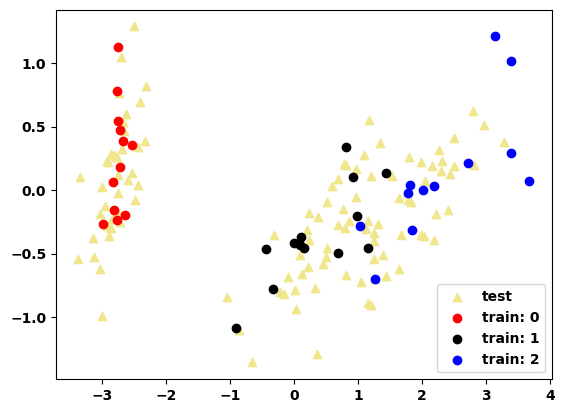

In [25]:
# Plotting the training and test sets
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_model = PCA()
transformed_data_2D = pca_model.fit_transform(X_train)

unlabeled_data = pca_model.transform(X_test)
plt.scatter(unlabeled_data[:,0], unlabeled_data[:,1], color='khaki', marker='^', label='test')

for label in range(3):
    data_subset = transformed_data_2D[y_train == label]
    plt.scatter(data_subset[:,0], data_subset[:,1], color=['r', 'k', 'b'][label], label=f'train: {label}')

plt.legend()
plt.show()

In [26]:
# Computing Euclidean distances between points
from sklearn.metrics.pairwise import euclidean_distances
distance_matrix = euclidean_distances(X_test, X_train)

f_train, f_test = X_test[0], X[0]
distance = distance_matrix[0][0]
print(f"Our fist test set feature is {f_train}")
print(f"Our first training set feature is {f_test}")
print(f"The Euclidean distance between the features is {distance:.2f}")

Our fist test set feature is [5.8 2.8 5.1 2.4]
Our first training set feature is [5.1 3.5 1.4 0.2]
The Euclidean distance between the features is 4.18


**K-nearest Neighbors (KNN)**:  
1. Sort all data points in the training set based on their distance to the unlabeled points   
2. Select the top K-nearest neighbors of the point   
3. Pick the most frequently occurring class across the K neighboring points

In [27]:
# Labeling a point based on its nearest neighbors
from collections import Counter
np.random.seed(6)
random_index = np.random.randint(y_test.size)
labeled_distances = distance_matrix[random_index]
labeled_neighbors = np.argsort(labeled_distances)[:3]
labels = y_train[labeled_neighbors]

top_label, count = Counter(labels).most_common()[0]
print(f"The 3 nearest neighbors of Point {random_index} have the following labels:\n{labels}")
print(f"\nThe most common class label is {top_label}. It occurs {count} times.")

The 3 nearest neighbors of Point 10 have the following labels:
[2 1 2]

The most common class label is 2. It occurs 2 times.


In [28]:
# Checking the true class of a predicted label
true_label = y_test[random_index]
print(f"The true class of Point {random_index} is {true_label}.")

The true class of Point 10 is 2.


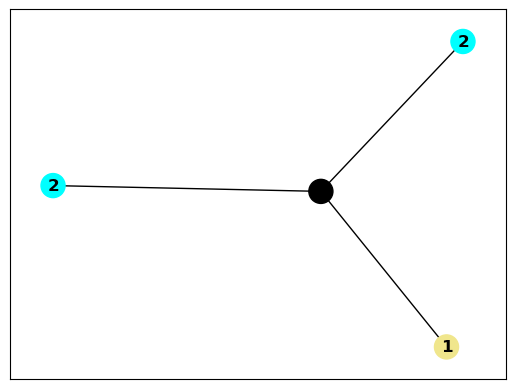

In [29]:
# Visualizing nearest neighbors with NetworkX
import networkx as nx
np.random.seed(0)

def generate_neighbor_graph(unlabeled_index, labeled_neighbors):
    G = nx.Graph()
    nodes = [(i, {'label': y_train[i]}) for i in labeled_neighbors]
    nodes.append((unlabeled_index, {'label': 'U'}))
    G.add_nodes_from(nodes)
    G.add_edges_from([(i, unlabeled_index) for i in labeled_neighbors])
    labels = y_train[labeled_neighbors]
    label_colors = ['pink', 'khaki', 'cyan']
    colors = [label_colors[y_train[i]] for i in labeled_neighbors] + ['k']
    labels = {i: G.nodes[i]['label'] for i in G.nodes}
    nx.draw_networkx(G, node_color=colors, labels=labels, with_labels=True)
    plt.show()
    return G

G = generate_neighbor_graph(random_index, labeled_neighbors)

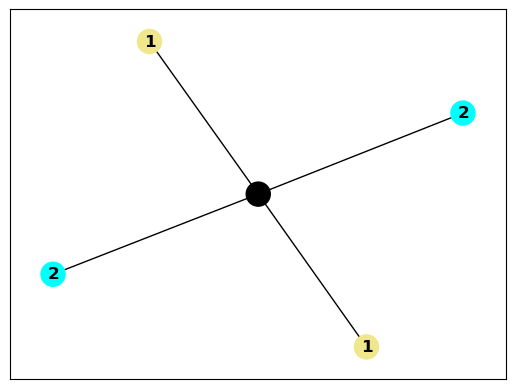

In [30]:
# Increasing the number of nearest neighbors
np.random.seed(0)
labeled_neighbors = np.argsort(labeled_distances)[:4]
G = generate_neighbor_graph(random_index, labeled_neighbors)

In [31]:
# Weighing votes of neighbors based on distance
from collections import defaultdict
class_to_votes = defaultdict(int)
for node in G.neighbors(random_index):
    label = G.nodes[node]['label']
    distance = distance_matrix[random_index][node]
    num_votes = 1 / distance
    print(f"A data point with a label of {label} is {distance:.2f} units away. It recieves {num_votes:.2f} votes.")
    class_to_votes[label] += num_votes

print()
for class_label, votes in class_to_votes.items():
    print(f"We counted {votes:.2f} votes for class {class_label}.")

top_class = max(class_to_votes.items(), key=lambda x: x[1])[0]
print(f"Class {top_class} has received the plurality of the votes.")

A data point with a label of 2 is 0.54 units away. It recieves 1.86 votes.
A data point with a label of 1 is 0.74 units away. It recieves 1.35 votes.
A data point with a label of 2 is 0.77 units away. It recieves 1.29 votes.
A data point with a label of 1 is 0.98 units away. It recieves 1.02 votes.

We counted 3.15 votes for class 2.
We counted 2.36 votes for class 1.
Class 2 has received the plurality of the votes.


## 20.2 Measuring Predicted Label Accuracy

In [32]:
# Parameterizing KNN predictions
# Predicts the label of a point using its row index in the distance matrix based on its K-nearest neighbors.
# The weighted_voting Boolean determines whether voting is weighted by neighbor distance.
def predict(index, K=1, weighted_voted=False):
    labeled_distances = distance_matrix[index]
    labeled_neighbors = np.argsort(labeled_distances)[:K]
    class_to_votes = defaultdict(int)
    for neighbor in labeled_neighbors:
        label = y_train[neighbor]
        distance = distance_matrix[index][neighbor]
        num_votes = 1 / max(distance, 1e-10) if weighted_voted else 1
        class_to_votes[label] += num_votes

    return max(class_to_votes, key=lambda x: class_to_votes[x])

assert predict(random_index, K=3) == 2
assert predict(random_index, K=4, weighted_voted=True) == 2

In [33]:
# Predicting all unlabeled flower classes
y_pred = np.array([predict(i) for i in range(y_test.size)])

In [34]:
# Comparing the predicted and actual classes
print(f"Predicted Classes:\n{y_pred}")
print(f"\nActual Classes:\n{y_test}")

Predicted Classes:
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 2 0 2 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 2 1 1 2 0 2 0 0 1 2 2 1 2 1 2 1 1 1 1 1 1 1 2 1 0 2 1 1 1 2 2 0 0 2 1 0 0
 1 0 2 1 0 1 2 1 0 2 2 2 2 0 0 2 2 0 2 0 2 2 0 0 2 0 0 0 1 2 2 0 0 0 1 1 0
 0 1]

Actual Classes:
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 1 1 1 2 0 2 0 0 1 2 2 2 2 1 2 1 1 2 2 2 2 1 2 1 0 2 1 1 1 1 2 0 0 2 1 0 0
 1 0 2 1 0 1 2 1 0 2 2 2 2 0 0 2 2 0 2 0 2 2 0 0 2 0 0 0 1 2 2 0 0 0 1 1 0
 0 1]


**Confusion/Error Matrix**: Each element M[i][j] counts the co-occurences between predicted Class i and actual Class j

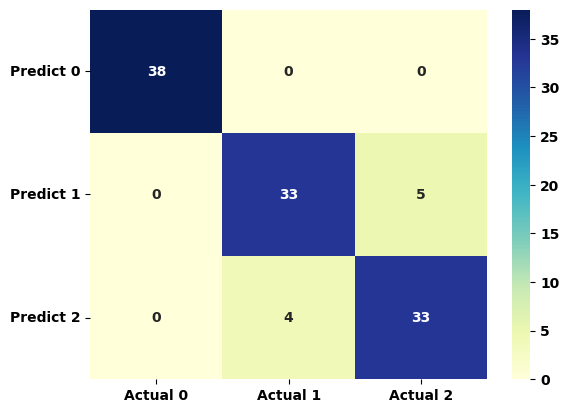

In [35]:
# Computing the confusion matrix
import seaborn as sns

# Computes the confusion matrix between y_pred and y_test
def compute_confusion_matrix(y_pred, y_test):
    num_classes = len(set(y_pred) | set(y_test))
    confusion_matrix = np.zeros((num_classes, num_classes))
    for prediction, actual in zip(y_pred, y_test):
        confusion_matrix[prediction][actual] += 1

    return confusion_matrix

M = compute_confusion_matrix(y_pred, y_test)
sns.heatmap(M, annot=True, cmap='YlGnBu', yticklabels=[f"Predict {i}" for i in range(3)], xticklabels=[f"Actual {i}" for i in range(3)])
plt.yticks(rotation=0)
plt.show()
# Each diagonal element counts the number of accurate precictions, also called true positives

In [36]:
# Counting the number of accurate predictions
num_accurate_predictions = M.diagonal().sum()
print(f"Our results contain {int(num_accurate_predictions)} accurate predictions.")

Our results contain 104 accurate predictions.


**Accuracy Score**: The fraction of total accurate predictions; Equal to M.diagonal().sum() / M.sum()

In [37]:
# Measuring the accuracy score
accuracy = M.diagonal().sum() / M.sum()
assert accuracy == 104 / 113
print(f"Our predictions are {100 * accuracy:.0f}% accurate.")

Our predictions are 92% accurate.


In [38]:
# Counting the predicted Class 1 elements
row1_sum = M[1].sum()
print(f"We've predicted that {int(row1_sum)} elements belong to Class 1.")

We've predicted that 38 elements belong to Class 1.


**Precision**: The true positive count divided by the sum of true positives and false positives; Equal to M[i][i] / M[i].sum()

In [39]:
# Computing the precision of Class 1
precision = M[1][1] / M[1].sum()
assert precision == 33 / 38
print(f"Precision of Class 1 is {precision:.2f}")

Precision of Class 1 is 0.87


**False Negative**: Elements that have been misidentified as belonging to a certain class  
**Recall**: The true postitive count divided by the sum of true postiives and false negatives; equal to M[i][i] / M[:,i].sum()

In [40]:
# Computing the recall of Class 1
recall = M[1][1] / M[:,1].sum()
assert recall == 33 / 37
print(f"Recall of Class 1 is {recall:.2f}")

Recall of Class 1 is 0.89


In [42]:
# hecking precision at a recall of 1.0
low_precision = M[1][1] / M.sum()
print(f"Precision at a trivially maximized recall is {low_precision:.2f}")

Precision at a trivially maximized recall is 0.29


In [43]:
# Taking the mean of the inverted metrics
inverse_average = (1 / precision + 1 / recall) / 2
print(f"The average of the inverted metrics is {inverse_average:.2f}")

The average of the inverted metrics is 1.14


In [44]:
# Taking the inverse of the inverted mean
result = 1 / inverse_average
print(f"The inverse of the average is {result:.2f}")

The inverse of the average is 0.88


**F-Measure**: The aggregated metric of precision and recall; can be computed by running 2 * precision * recall / (precision + recall)

In [45]:
# Computing the f-measure of Class 1
f_measure = 2 * precision * recall / (precision + recall)
print(f"The f-measure of Class 1 is {f_measure:.2f}")

The f-measure of Class 1 is 0.88


In [46]:
# Test case: One true positive, one false positive, zero false negatives; What are precision, recall, and f-measure?
# Comparing the f-measure to the average
tp, fp, fn = 1, 1, 0
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_measure = 2 * precision * recall / (precision + recall)
average = (precision + recall) / 2
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Average: {average}")
print(f"F-measure: {f_measure:.2f}")

Precision: 0.5
Recall: 1.0
Average: 0.75
F-measure: 0.67


In [47]:
# Computing the f-measure for each class
def compute_f_measure(M):
    precisions = M.diagonal() / M.sum(axis=0)
    recalls = M.diagonal() / M.sum(axis=1)
    return 2 * precisions * recalls / (precisions + recalls)

f_measures = compute_f_measure(M)
for class_label, f_measure in enumerate(f_measures):
    print(f"The f-measure for Class {class_label} is {f_measure:.2f}")

The f-measure for Class 0 is 1.00
The f-measure for Class 1 is 0.88
The f-measure for Class 2 is 0.88


In [48]:
# Computing a unified f-measure for all classes
avg_f = f_measures.mean()
print(f"Our unified f-measure equals {avg_f:.2f}")

Our unified f-measure equals 0.92


**Imbalance In Data**: There are far more instances of some Class A than some Class B

In [50]:
# Comparing performance metrics across imbalanced data
M_imbalanced = np.array([[99, 0], [1, 1]])
accuracy_imb = M_imbalanced.diagonal().sum() / M_imbalanced.sum()
f_measure_imb = compute_f_measure(M_imbalanced).mean()
print(f"The accuracy for our imbalanced dataset is {accuracy_imb:.2f}")
print(f"The f-measure for our imbalanced dataset is {f_measure_imb:.2f}")
# Notice that f_measure is a better metric to show precision as well as accuracy, rather than just accuracy

The accuracy for our imbalanced dataset is 0.99
The f-measure for our imbalanced dataset is 0.83


### 20.2.1 Scikit-learn's Prediction Measurement Functions

In [51]:
# Computing the confusion matrix using scikit-learn
from sklearn.metrics import confusion_matrix
new_M = confusion_matrix(y_pred, y_test)
assert np.array_equal(new_M, M)
print(new_M)

[[38  0  0]
 [ 0 33  5]
 [ 0  4 33]]


In [52]:
# Computing the accuracy using scikit-learn
from sklearn.metrics import accuracy_score
assert accuracy_score(y_pred, y_test) == accuracy

In [53]:
# Computing all f-measures using scikit-learn
from sklearn.metrics import f1_score
new_f_measures = f1_score(y_pred, y_test, average=None)
assert np.array_equal(new_f_measures, f_measures)
print(new_f_measures)

[1.   0.88 0.88]


In [55]:
# Comparing a unified f-measure using scikit-learn
new_f_measure = f1_score(y_pred, y_test, average='macro')
assert new_f_measure == new_f_measures.mean()
assert new_f_measure == avg_f

## 20.3 Optimizing KNN Performance

**Hyperparameters:** Parameters that must be set before training and influence the classifier's performance

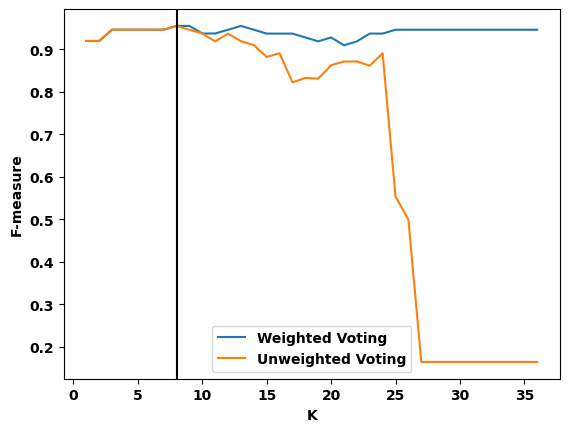

In [56]:
# Optimizing KNN hyperparameters
k_values = range(1, y_train.size)
weighted_voting_bools = [True, False]
f_scores = [[], []]

params_to_f = {}
for k in k_values:
    for i, weighted_voting in enumerate(weighted_voting_bools):
        y_pred = np.array([predict(i, K=k, weighted_voted=weighted_voting) for i in range(y_test.size)])
        f_measure = f1_score(y_pred, y_test, average='macro')
        f_scores[i].append(f_measure)
        params_to_f[(k, weighted_voting)] = f_measure

(best_k, best_weighted), best_f = max(params_to_f.items(), key=lambda x: x[1])
plt.plot(k_values, f_scores[0], label='Weighted Voting')
plt.plot(k_values, f_scores[1], label='Unweighted Voting')
plt.axvline(best_k, c='k')
plt.xlabel('K')
plt.ylabel('F-measure')
plt.legend()
plt.show()

**Parameter Sweep / Grid Search**: Exhaustively iterating over all the possible input parameters; simple to execute, but can be computationally slow with more parameters; however, can be parallelize  
Steps for Grid Search:  
1. Select our  hyper parameters  
2. Assign a range of values to each hyperparameter  
3. Split our input data into a training set and a validation set. The validation set is used to measure the prediction quality  
4. Iterate over all possible hyperparameter combinations  
5. At each iteration, train a classifier on the training data using the specified hyperparameters  
6. Measure the classifier's performance using the validation set  
7. Once all iterations are completed, return the hyperparameter combination with the highest metric output

## 20.4 Running a Grid Search Using Scikit-Learn

In [57]:
# Importing scikit-learn's KNN class
from sklearn.neighbors import KNeighborsClassifier